 ## `polar_plots_cccma.ipynb`: code creates 5 by 8 plot of all ensembles CanESM5 model polar plots, and 3 by 6 plots of each decade for one ensemble.

In [1]:
# import modules
import context
import warnings
import intake
import xarray as xr 
import matplotlib.pyplot as plt 
import pandas as pd
import cftime
import gcsfs
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
from a448_lib import data_read
import fsspec
import cmocean as cm
import cartopy.feature as cfeature
import numpy as np
import warnings
import matplotlib.path as mpath

found this_dir=PosixPath('/home/jovyan/work/data_share')
found lib_dir=PosixPath('/home/jovyan/work/data_share/a448_lib')
******************************
context imported. Front of path:
/home/jovyan/work/data_share
back of path: /home/jovyan/.ipython
******************************



* Download the catalog in csv and json format

### Grab json file with all of the data from cmip6

In [2]:
csv_filename = "pangeo-cmip6.csv"
root = "https://storage.googleapis.com/cmip6"
if Path(csv_filename).is_file():
    print(f"found {csv_filename}")
else:
    print(f"downloading {csv_filename}")
    data_read.download(csv_filename,root=root)
    
json_filename="https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

found pangeo-cmip6.csv


* make a dataframe from the csv version

In [3]:
catalog_df=pd.read_csv(csv_filename)
catalog_df.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon        hurs         gn   
1     Amon        tauv         gn   
2     Amon          ta         gn   
3     Amon         tas         gn   
4     Amon      tasmax         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

* make an intake collection from the json version

In [4]:
col = intake.open_esm_datastore(json_filename)

In [5]:
col

## First show all 40 CCCma historical runs

In [6]:
source = "CanESM5"
query = dict(
    experiment_id=['historical'],
    institution_id = "CCCma",
    source_id = source,
    table_id=["SImon"],
    variable_id=['sithick'])

col_subset = col.search(require_all_on=["source_id"],**query)

In [7]:
col_subset.df.head()

activity_id institution_id source_id experiment_id  member_id table_id  \
0        CMIP          CCCma   CanESM5    historical  r33i1p2f1    SImon   
1        CMIP          CCCma   CanESM5    historical  r32i1p2f1    SImon   
2        CMIP          CCCma   CanESM5    historical  r30i1p2f1    SImon   
3        CMIP          CCCma   CanESM5    historical   r2i1p2f1    SImon   
4        CMIP          CCCma   CanESM5    historical  r29i1p2f1    SImon   

  variable_id grid_label                                             zstore  \
0     sithick         gn  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...   
1     sithick         gn  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...   
2     sithick         gn  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...   
3     sithick         gn  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...   
4     sithick         gn  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...   

   dcpp_init_year   version  
0             NaN  20190429  
1             NaN  20190429  
2             NaN  20190429  
3             NaN  20190429  
4             NaN  20190429

In [8]:
len(col_subset.df)

list_of_members = col_subset.df

## get the first realization for the sithick dataset

In [9]:
member = 'r1i1p2f1'
filename=col_subset.df.query("member_id=='r1i1p2f1'")['zstore'].iloc[0]

In [10]:
dset_cccma_sithick=xr.open_zarr(fsspec.get_mapper(filename), consolidated=True)
dset_cccma_sithick

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 360, j: 291, time: 1980, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
  * time                (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    sithick             (time, j, i) float32 dask.array<chunksize=(727, 291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/57)
    CCCma_model_hash:            8ac7a3c953a92eb65289508ded4d1b280d2bae9e
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           97abcef62ae02c3bf113b47d71d9aa20392aacfc
    CCCma_runid:                 p2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    DISCLAIMER:                  PRELIMINARY DATA - NOT FOR PUBLICATION.
    ...                          ...
    tracking_id:                 hdl:21.14100/996c814e-a60f-4334-948f-38b9663...
    variable_id:                 sithick
    variant_label:               r1i1p2f1
    version:                     v20190429
    netcdf_tracking_ids:         hdl:21.14100/996c814e-a60f-4334-948f-38b9663...
    version_id:                  v20190429

## Now get the cell area for the ocean grid

In [11]:
query = dict(
    experiment_id=['historical'],
    institution_id = "CCCma",
    table_id = "Ofx",
    source_id = source,
    member_id = member,
    variable_id=['areacello'])

col_subset = col.search(require_all_on=["source_id"],**query)
col_subset.df

activity_id institution_id source_id experiment_id member_id table_id  \
0        CMIP          CCCma   CanESM5    historical  r1i1p2f1      Ofx   

  variable_id grid_label                                             zstore  \
0   areacello         gn  gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical...   

   dcpp_init_year   version  
0             NaN  20190429

In [12]:
filename=col_subset.df['zstore'].iloc[0]
filename

'gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p2f1/Ofx/areacello/gn/v20190429/'

In [13]:
dset_cccma_areacello=xr.open_zarr(fsspec.get_mapper(filename), consolidated=True)
dset_cccma_areacello

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/55)
    CCCma_model_hash:            8ac7a3c953a92eb65289508ded4d1b280d2bae9e
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 areacello
    variant_label:               r1i1p2f1
    version:                     v20190429
    status:                      2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/9194f67c-fb32-41ba-a83a-d44d2bb...
    version_id:                  v20190429

## Plot the lat/lon for this curvilinear ocean grid

In [14]:
lons = dset_cccma_sithick.longitude
lats = dset_cccma_sithick.latitude
data = dset_cccma_sithick['sithick']

In [15]:
lons.shape
lats.shape
data.shape

(1980, 291, 360)

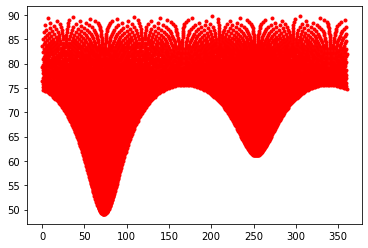

In [16]:
plt.plot(lons[-30:],lats[-30:],'r.');

In [17]:
def deseam(lon, lat, data):
    """
    Function to get rid of the "seam" that shows up on 
    the map when you're using these curvilinear grids.
    """
    i, j = lat.shape
    new_lon = np.zeros((i, j + 1))
    new_lon[:, :-1] = lon
    new_lon[:, -1] = lon[:, 0]

    new_lat = np.zeros((i, j + 1))
    new_lat[:, :-1] = lat
    new_lat[:, -1] = lat[:, 0]

    new_data = np.zeros((i, j + 1))
    new_data[:, :-1] = data
    new_data[:, -1] = data[:, 0]
    new_data = np.ma.array(new_data, mask=np.isnan(new_data))
    return new_lon, new_lat, new_data

In [18]:
lons, lats, newdata = deseam(lons,lats,data[0,:,:])

## Plot single polar plot from 2014
* Can change the title and the year to look at any year of data

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


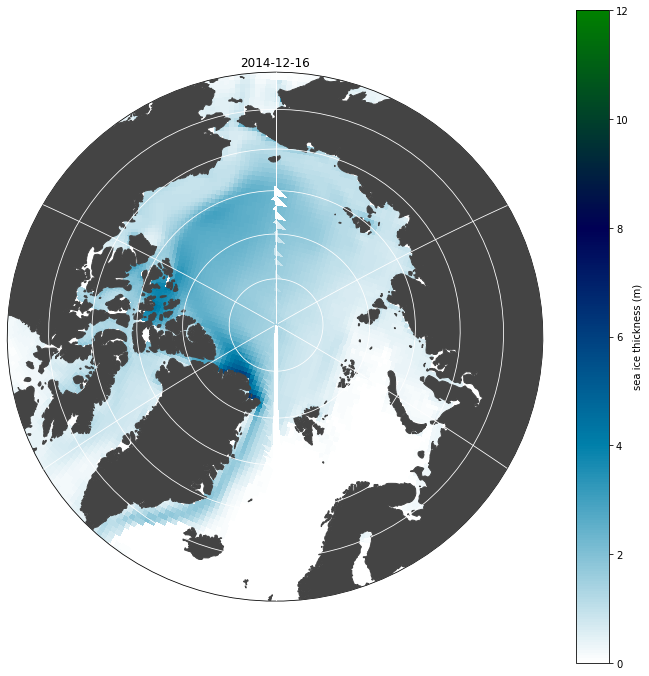

In [19]:
lons = dset_cccma_sithick.longitude
lats = dset_cccma_sithick.latitude
data = dset_cccma_sithick['sithick']
    
lons, lats, newdata = deseam(lons,lats,data[-1,:,:])
    
    
f, ax = plt.subplots(1,1,figsize=(12,12),
                     subplot_kw=dict(projection=ccrs.Orthographic(0, 80)))




ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

# Add land.
ax.add_feature(cfeature.LAND, color='#444444', zorder=4);
ax.gridlines(color = "white", zorder=5)


theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

p = ax.pcolormesh(lons,
              lats,
              newdata,
              transform=ccrs.PlateCarree(),
              vmin=0, vmax=12, cmap='ocean_r')
f.colorbar(p, label='sea ice thickness (m)')
ax.set_title('2014-12-16')

plt.show()

## Plot 18 polar plots of once a decade from 1850 -> 2014 to use in the report

In [20]:
# set time step
time_step = 120
years = [0,1*time_step, 2*time_step, 3*time_step, 4*time_step, 5*time_step, 6*time_step, 7*time_step, 8*time_step, 9*time_step, 10*time_step, 11*time_step, 12*time_step, 13*time_step,14*time_step, 15*time_step, 16*time_step, 1979]

every_ten_years = dset_cccma_sithick['sithick'][years,:,:]
every_ten_years_time = dset_cccma_sithick['time'][years]

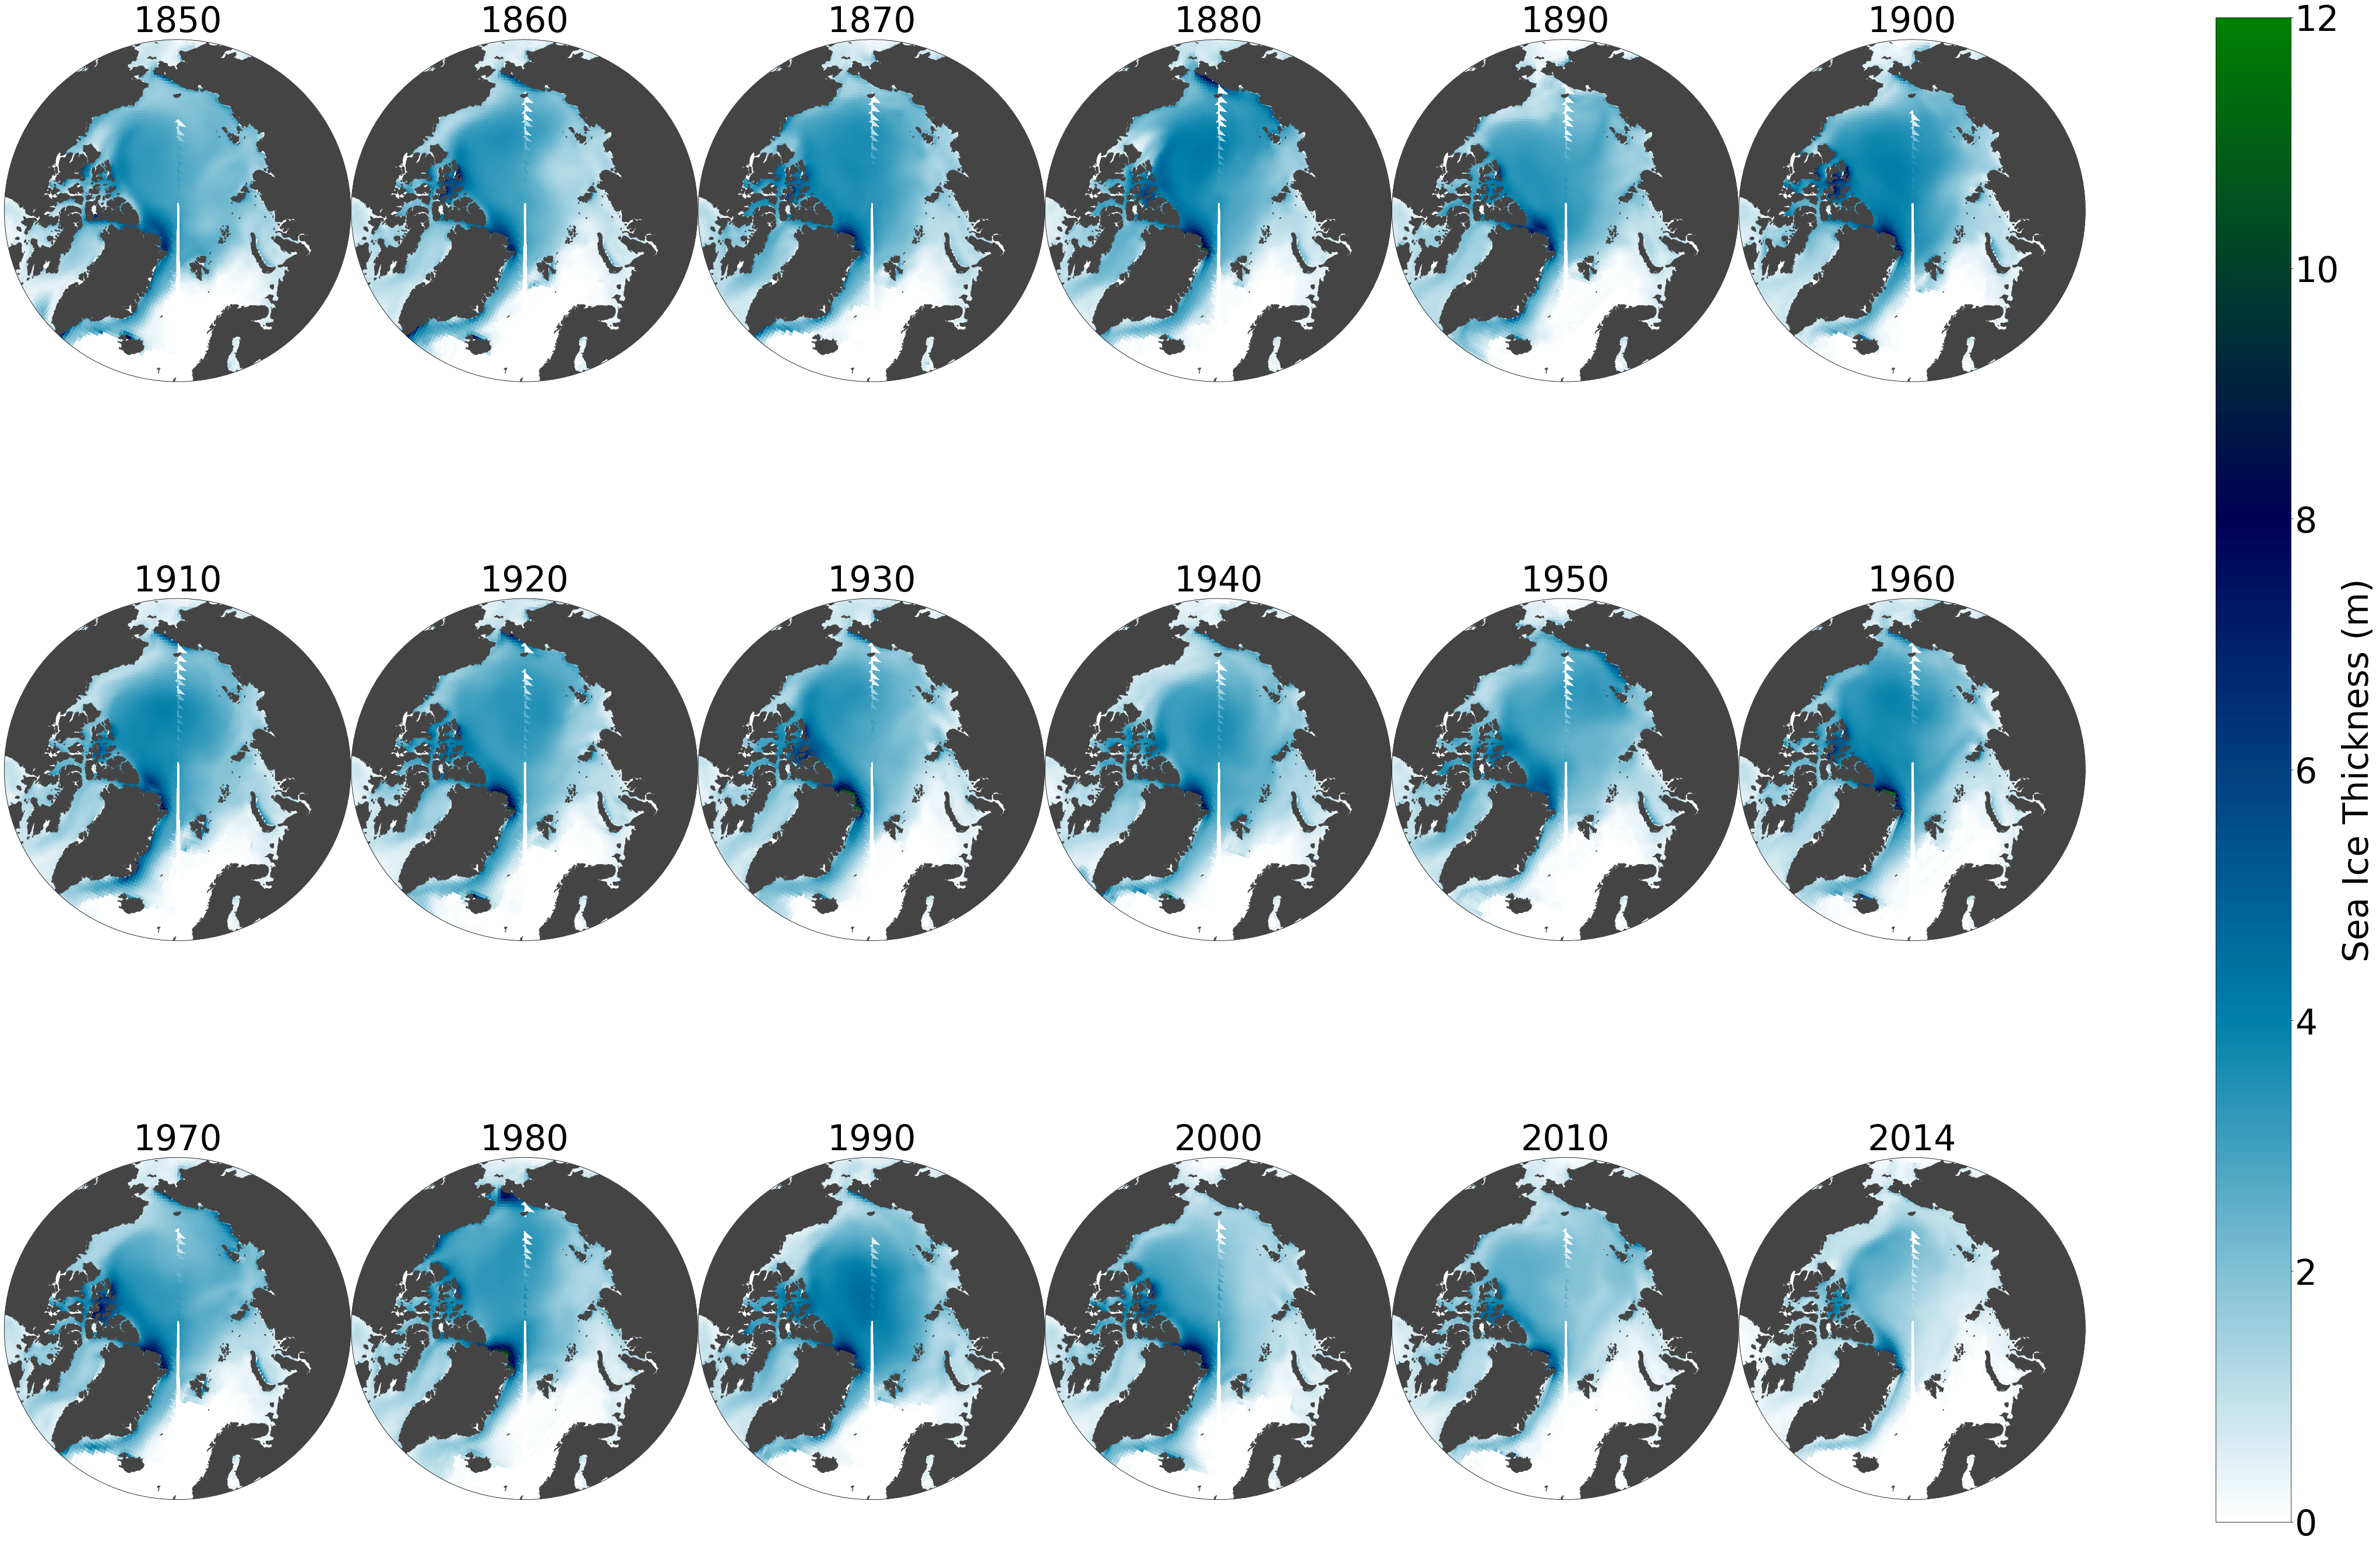

In [21]:
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(3,6, figsize=(80, 50), facecolor='w', edgecolor='k', subplot_kw={'projection': ccrs.Orthographic(0, 80)})
fig.subplots_adjust(hspace = .2, wspace=.001)

axs = axs.ravel()

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)


font = {
        'size': 60,
        }


icount = 0
for i in years: 
    
    # plotting
    
    lons = dset_cccma_sithick.longitude
    lats = dset_cccma_sithick.latitude
    data = dset_cccma_sithick['sithick']
    
    lons, lats, newdata = deseam(lons,lats,data[i,:,:])
    
    axs[icount].set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

    # Add land.
    axs[icount].add_feature(cfeature.LAND, color='#444444', zorder=4);
   # ax.gridlines(color = "white", zorder=5)


    axs[icount].set_boundary(circle, transform=axs[icount].transAxes)
    
    im = axs[icount].pcolormesh(lons,
                  lats,
                  newdata,
                  transform=ccrs.PlateCarree(),
                  vmin=0, vmax=12, cmap='ocean_r')
    
    axs[icount].set_title(str(every_ten_years_time[icount].dt.year.values),fontdict = font)

    icount = icount + 1

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95, orientation="vertical")
cbar.set_label("Sea Ice Thickness (m)", size = 60)
cbar.ax.tick_params(labelsize = 60)

#plt.savefig('decade_polarplots.png')
plt.show()    

## Now do a mean climatology: 1970-2000

In [22]:
# Take a seasonal climatology over 1970-2000
climatology = dset_cccma_sithick['sithick'].sel(time=slice('1970', '2000')).groupby('time.season').mean('time')

In [23]:
JJA = climatology.sel(season='JJA').squeeze()
lons, lats, data = deseam(JJA.longitude, JJA.latitude, JJA)

Not using the climatology in this research project, but the code is here if any interest in expanding

## Take the area-weighted mean

In [24]:
dset_cccma_areacello

<xarray.Dataset>
Dimensions:             (i: 360, j: 291, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
  * j                   (j) int32 0 1 2 3 4 5 6 ... 284 285 286 287 288 289 290
    latitude            (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
    longitude           (j, i) float64 dask.array<chunksize=(291, 360), meta=np.ndarray>
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(291, 360), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float64 dask.array<chunksize=(291, 360, 4), meta=np.ndarray>
Attributes: (12/55)
    CCCma_model_hash:            8ac7a3c953a92eb65289508ded4d1b280d2bae9e
    CCCma_parent_runid:          p2-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 p2-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    ...                          ...
    variable_id:                 areacello
    variant_label:               r1i1p2f1
    version:                     v20190429
    status:                      2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:         hdl:21.14100/9194f67c-fb32-41ba-a83a-d44d2bb...
    version_id:                  v20190429

In [25]:
areacello = dset_cccma_areacello['areacello'].squeeze()

(1980, 291, 360)

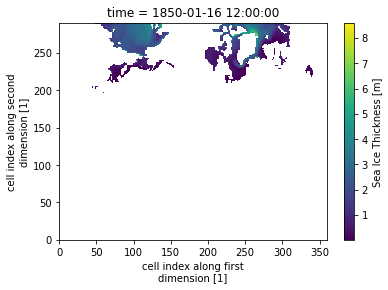

In [26]:
sithick = dset_cccma_sithick['sithick'].squeeze()

# Grab north of the equator
arctic_ice = sithick.where(areacello.latitude > 0)
arctic_ice.isel(time=0).plot();
arctic_ice.shape

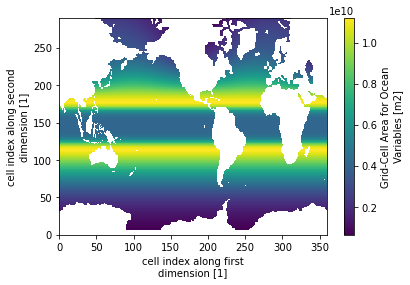

In [27]:
areacello.plot();

In [28]:
# compute area-weighted mean
aw_arctic_ice = (arctic_ice * areacello).sum(['j', 'i']) / areacello.sum()

In [29]:
aw_arctic_ice = aw_arctic_ice.compute()

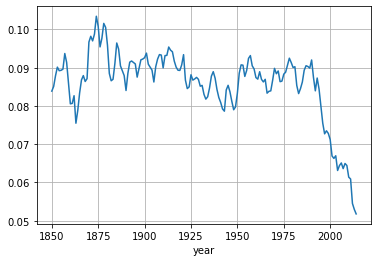

In [30]:
fig, ax = plt.subplots(1,1)
lines = aw_arctic_ice.groupby('time.year').mean('time').plot(ax=ax)
ax.grid(True)

In [31]:
member_ids = list_of_members['member_id']

## Create polar plots for the first time-step in plots (1850)
* Note: figure is currently set up to look nice on a report, it is quite large

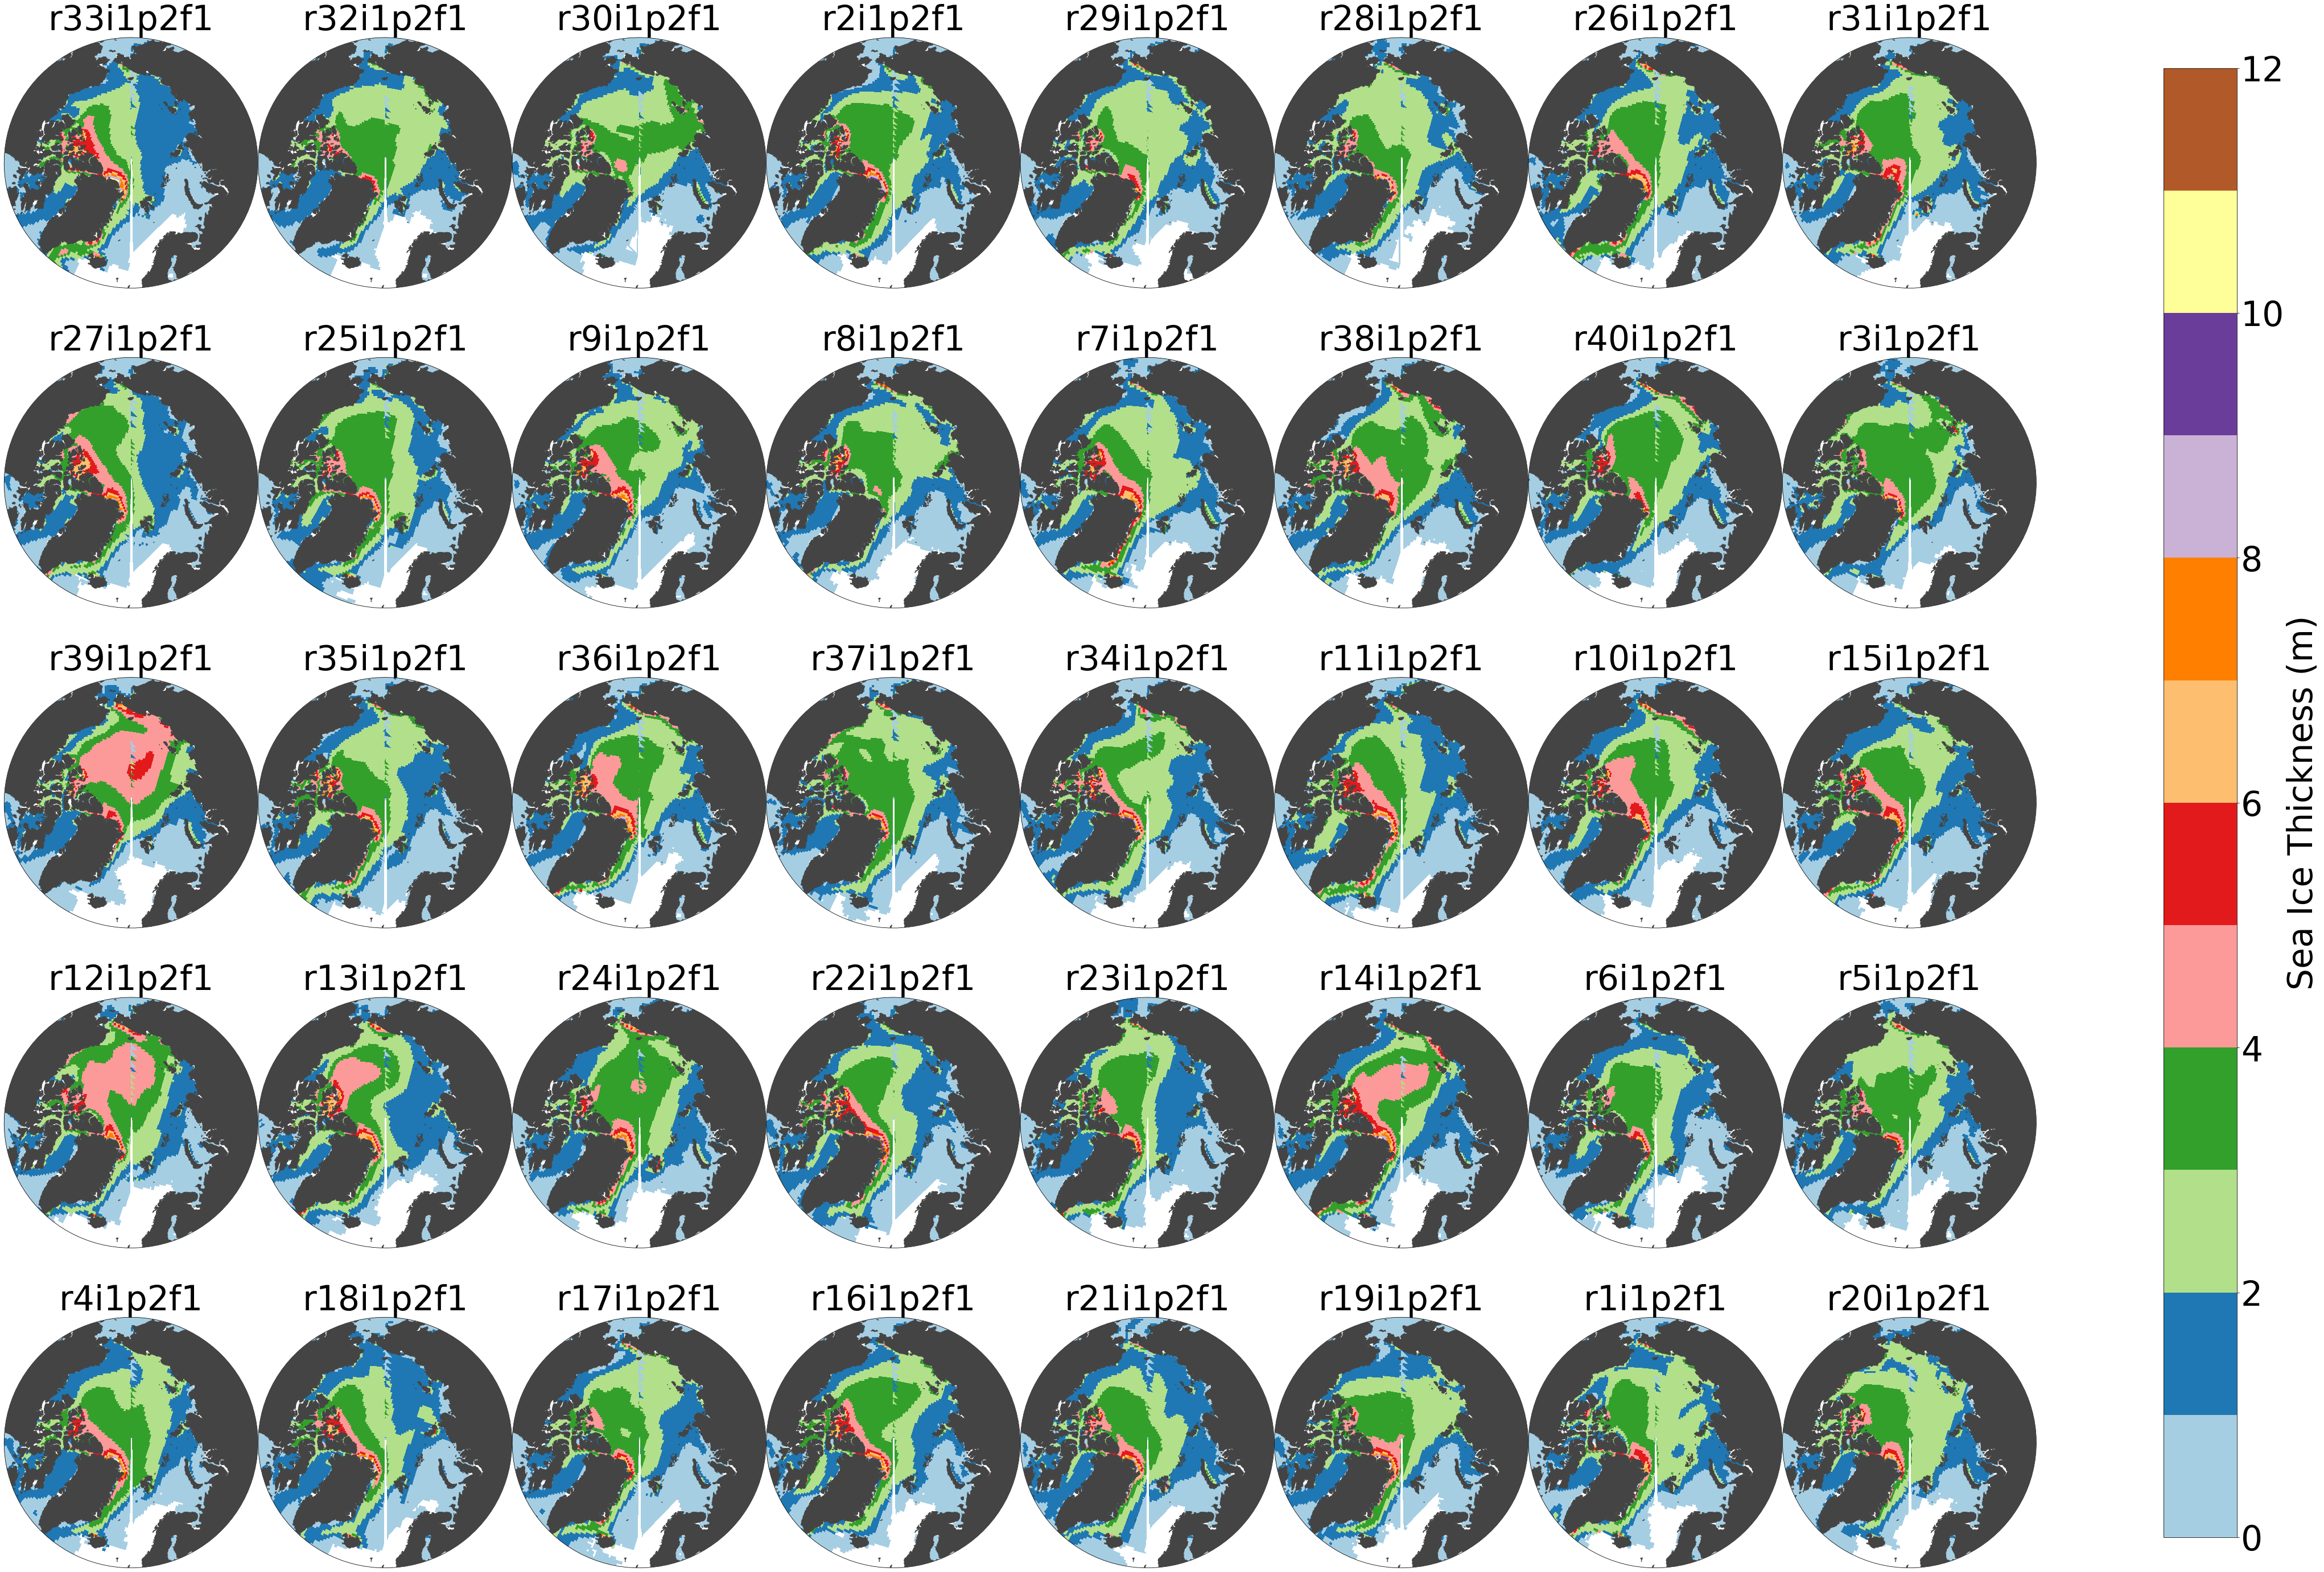

In [32]:
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(5,8, figsize=(80, 50), facecolor='w', edgecolor='k', subplot_kw={'projection': ccrs.Orthographic(0, 80)})
fig.subplots_adjust(hspace = .2, wspace=.001)

axs = axs.ravel()

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)


font = {
        'size': 60,
        }


icount = 0
for i in member_ids:
    my_memberid = "member_id==" + "\'" + str(i) +"\'"
    filenames = list_of_members.query(my_memberid)['zstore'].iloc[0]
    dset_cccma_sithick=xr.open_zarr(fsspec.get_mapper(filenames), consolidated=True)
    
    # plotting
    
    lons = dset_cccma_sithick.longitude
    lats = dset_cccma_sithick.latitude
    data = dset_cccma_sithick['sithick']
    
    lons, lats, newdata = deseam(lons,lats,data[0,:,:])
    
    axs[icount].set_extent([-180, 180, 60, 90], ccrs.PlateCarree())

    # Add land.
    axs[icount].add_feature(cfeature.LAND, color='#444444', zorder=4);
   # ax.gridlines(color = "white", zorder=5)


    axs[icount].set_boundary(circle, transform=axs[icount].transAxes)
    
    im = axs[icount].pcolormesh(lons,
                  lats,
                  newdata,
                  transform=ccrs.PlateCarree(),
                  vmin=0, vmax=12, cmap='Paired')
    
    axs[icount].set_title(str(i),fontdict = font)

    icount = icount + 1

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.95, orientation="vertical")
cbar.set_label("Sea Ice Thickness (m)", size = 60)
cbar.ax.tick_params(labelsize = 60)

#plt.savefig('1850_cccma_polar_plots .png')
plt.show()    